In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

df = pd.concat([train, val, test], axis=0).reset_index(drop=True)

train_idx = df.iloc[:len(train), :].index
val_idx = df.iloc[len(train):len(train)+len(val), :].index
test_idx = df.iloc[len(train)+len(val):, :].index

train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [4]:
data = [[n[:8]+p+c[8:], prot, lab] for _, n, c, __, ___, prot, p, lab in train.values]
train_new = pd.DataFrame(data, columns=['peptide', 'protein', 'ID'])

data = [[n[:8]+p+c[8:], prot, lab] for _, n, c, __, ___, prot, p, lab in val.values]
val_new = pd.DataFrame(data, columns=['peptide', 'protein', 'ID'])

data = [[n[:8]+p+c[8:], prot, lab] for _, n, c, __, ___, prot, p, lab in test.values]
test_new = pd.DataFrame(data, columns=['peptide', 'protein', 'ID'])

# torch gpu

In [5]:
import sys
PATH_TO_REPO = "/home/bis/2021_AIhub/esm/"
sys.path.append(PATH_TO_REPO)

import torch
import esm

from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook
import time
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW
# from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup

In [6]:
##GPU 사용 시
device = torch.device("cuda")

In [7]:
esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [8]:
ct = 0
for child in esm_model.children():
    ct += 1
#     print(ct, child)
#     if ct < 7:
    for param in child.parameters():
        param.requires_grad = False

In [9]:
class ESMDataset(Dataset):
    def __init__(self, datasets, idxes):
        pep_idx, label_idx = idxes
        pep_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, pep_idx])]
        labels, pep_strs, pep_tokens = batch_converter(pep_data)

        self.sentences = pep_tokens
        self.labels = labels

    def __getitem__(self, i):
        return ((self.sentences[i], ) + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

# [PAD] = 1, [MASK] = 21  [CLS] = 0 (special classification token), [SEP] = 2 (seperate segment), Z = 27, '-' = 30, .=29, ,=28
# J 없음
# A 2, B 25, C 23, D 13, E 9, F 18, G 6, H 21, I 12, K 15, L 4, M 20, N 17, 
# O 28, P 14, Q 16, R 10, S 8, T 11, U 26, V 7, W 22, X 24, Y 19, Z 27
# 3 5 없음

In [10]:
## Setting parameters
max_len = 30
batch_size = 256
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-4

In [11]:
s = time.time()

dataset_train = train_new[['peptide', 'ID']].values
dataset_valid = val_new[['peptide', 'ID']].values
dataset_test = test_new[['peptide', 'ID']].values

data_train = ESMDataset(dataset_train, [0, 1])
data_valid = ESMDataset(dataset_valid, [0, 1])
data_test = ESMDataset(dataset_test, [0, 1])

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=48)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=48)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=48)

e = time.time()
print(round(e-s, 2),'sec')

230.83 sec


# model

In [12]:
class ESMClassifier(nn.Module):
    def __init__(self,
                 esm,
                 num_classes=1,
                 params=None):
        
        super(ESMClassifier, self).__init__()
        self.esm = esm
        self.pep_lstm1 = nn.LSTM(input_size=1280, hidden_size=128, batch_first=True)
        self.pep_drop1 = nn.Dropout(p=0.2)
        
        self.ts_lstm1 = nn.LSTM(input_size=1280, hidden_size=64, batch_first=True)
        self.ts_drop1 = nn.Dropout(p=0.2)
                
        self.fc1 = nn.Linear(384, 128)
        self.fc_drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 1)


    def forward(self, token_ids):        
        pep_dig_embed = self.esm(token_ids, repr_layers=[33])['representations'][33]
        
        pad_ids = torch.tensor([[0, 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2]]*len(token_ids)).long().to(device)
        pad_vec = self.esm(pad_ids, repr_layers=[33])['representations'][33]  # 15mer
        pad_vec = torch.stack([pad_vec[row_idx][1:-1] for row_idx in range(len(pad_vec))])
        
        pep_embed = torch.stack([pep_dig_embed[row_idx][8:-7] for row_idx in range(len(pep_dig_embed))])
        en_embed = torch.stack([pep_dig_embed[row_idx][:15] for row_idx in range(len(pep_dig_embed))])
        ec_embed = torch.stack([pep_dig_embed[row_idx][-15:] for row_idx in range(len(pep_dig_embed))])
        
        lpad = torch.tensor([0]*8).long().to(device)
        rpad = torch.tensor([0]*8).long().to(device)
        pep_ids = torch.stack([torch.cat([lpad, token_ids[row_idx][8:-8], rpad]) for row_idx in range(len(token_ids))])  # __KR에서 마지막 ts 제외한 ids.
        e1_embed = []
        e2_embed = []
        for row_idx, pep_id in enumerate(pep_ids):
            k_idx = (pep_id==15).nonzero(as_tuple=True)[0]
            r_idx = (pep_id==10).nonzero(as_tuple=True)[0]
            ts_idx = torch.sort(torch.cat([k_idx, r_idx],dim=0))[0]  # 0 : nterm, 1: m1, 2: m2, 3: cterm, if len(ts_idx)==4
            
            if len(ts_idx)==1:
                e1 = pep_dig_embed[row_idx][ts_idx[0]-7:ts_idx[0]+8]  # 15mer (15*1280 shape)
                e2 = pad_vec[row_idx]  # 15*1280
                # e2_embed = torch.tensor([[0]*1280]*15).long().to(device)
            elif len(ts_idx)==2:
                e1 = pep_dig_embed[row_idx][ts_idx[0]-7:ts_idx[0]+8]
                e2 = pep_dig_embed[row_idx][ts_idx[1]-7:ts_idx[1]+8]
            else:
                e1 = pad_vec[row_idx]
                e2 = pad_vec[row_idx]
            e1_embed.append(e1)
            e2_embed.append(e2)
            
        e1_embed = torch.stack(e1_embed)
        e2_embed = torch.stack(e2_embed)
        
        pep_lstm, (pep_hn, __) = self.pep_lstm1(pep_embed)
        en_lstm, (en_hn, __) = self.ts_lstm1(en_embed)
        ec_lstm, (ec_hn, __) = self.ts_lstm1(ec_embed)
        e1_lstm, (e1_hn, __) = self.ts_lstm1(e1_embed)
        e2_lstm, (e2_hn, __) = self.ts_lstm1(e2_embed)
        
        merge = torch.cat([pep_hn[0], en_hn[0], ec_hn[0], e1_hn[0], e2_hn[0]], dim=1)
        merge = self.fc1(merge)
        merge = self.fc_drop1(merge)
        merge = self.fc2(merge)
        
        out = torch.sigmoid(merge)
        
        return out

In [13]:
model = ESMClassifier(esm_model).to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
def calc_accuracy(X,Y):
    train_acc = ((X>0.5)==Y).sum().data.cpu().numpy() / len(Y)
    return train_acc

In [15]:
best_acc = 0
for e in range(num_epochs):
    t0 = time.time()
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (pep_token_ids, label) in enumerate(train_dataloader):
#         print(batch_id, round(time.time()-t0, 2))  # batch256->2100 loop, each 5 sec -> per 1 epoch, 3h
        
        pep_token_ids = pep_token_ids.long().to(device)
        label = torch.reshape(label.float(), (-1, 1)).to(device)
        
        pred = model(pep_token_ids)
        loss = F.binary_cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += calc_accuracy(pred, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {} time {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1), round(time.time()-t0, 2)))
        
    print("epoch {} train acc {} time {}".format(e+1, train_acc / (batch_id+1), round(time.time()-t0,2)))
    
    model.eval()
    for batch_id, (pep_token_ids, label) in enumerate(valid_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))
        pred = model(pep_token_ids)
        
        test_acc += calc_accuracy(pred, label)
    test_acc = test_acc / (batch_id+1)
    if test_acc > best_acc:
        best_acc=test_acc
        print(f"best_acc: {best_acc}")
        torch.save({"best_acc":best_acc, "model":model.state_dict()},f'./finetuning_211221_1M.pl')
    print("epoch {} test acc {}".format(e+1, test_acc))

epoch 1 batch id 1 loss 0.6949113607406616 train acc 0.5078125 time 12.2
epoch 1 batch id 201 loss 0.5441871881484985 train acc 0.679629197761194 time 1630.22
epoch 1 batch id 401 loss 0.5058050155639648 train acc 0.7015371726932669 time 3248.51
epoch 1 batch id 601 loss 0.5291488170623779 train acc 0.7118864392678869 time 4866.79
epoch 1 batch id 801 loss 0.502938985824585 train acc 0.722475811485643 time 6483.21
epoch 1 batch id 1001 loss 0.4696585237979889 train acc 0.7303243631368631 time 8105.0
epoch 1 batch id 1201 loss 0.44798171520233154 train acc 0.7381901800582847 time 9728.39
epoch 1 batch id 1401 loss 0.5074709057807922 train acc 0.7451959537830122 time 11352.33
epoch 1 batch id 1601 loss 0.4664769172668457 train acc 0.7510296299188007 time 12974.33
epoch 1 batch id 1801 loss 0.4033125638961792 train acc 0.7560361431149362 time 14595.7
epoch 1 batch id 2001 loss 0.44314101338386536 train acc 0.7601550787106447 time 16214.54
epoch 1 train acc 0.76252795433145 time 17200.2
be

epoch 8 batch id 2001 loss 0.3042428493499756 train acc 0.880036544227886 time 13277.32
epoch 8 train acc 0.8802487935499058 time 13853.78
epoch 8 test acc 0.8113444562146892
epoch 9 batch id 1 loss 0.27555394172668457 train acc 0.88671875 time 9.34
epoch 9 batch id 201 loss 0.25121089816093445 train acc 0.8853000621890548 time 961.08
epoch 9 batch id 401 loss 0.25639835000038147 train acc 0.8865726309226932 time 1913.31
epoch 9 batch id 601 loss 0.29821479320526123 train acc 0.8848533693843594 time 2865.36
epoch 9 batch id 801 loss 0.32717180252075195 train acc 0.8849143648564295 time 3817.55
epoch 9 batch id 1001 loss 0.2810322940349579 train acc 0.8850212287712288 time 4769.57
epoch 9 batch id 1201 loss 0.2560262084007263 train acc 0.8854437708159867 time 5721.58
epoch 9 batch id 1401 loss 0.32942360639572144 train acc 0.8856648153104925 time 6673.27
epoch 9 batch id 1601 loss 0.24927166104316711 train acc 0.8859745861961275 time 7624.92
epoch 9 batch id 1801 loss 0.2504426240921020

# test

In [21]:
pred = []
model.eval()
with torch.no_grad():
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(test_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))

        pred_batch = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        pred += list(pred_batch)
        test_acc += calc_accuracy(pred_batch, label)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     66996
           1       0.82      0.83      0.83     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992



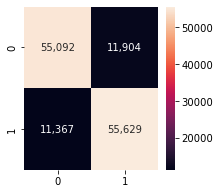

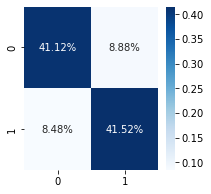

accuracy: 0.8263254522658069


In [22]:
y_test = test.ID.values
y_pred = [1 if _ >= 0.5 else 0 for _ in pred]
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

print('accuracy:', sum(np.array(y_pred)==y_test)/ len (y_pred))

In [35]:
probs = [_.cpu().numpy() for _ in pred]

rf auc : 0.9022046666888106


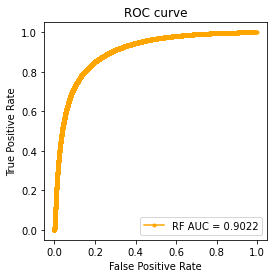

In [36]:
rf_auc = roc_auc_score(y_test, probs)


print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [37]:
torch.save({"model":model.state_dict()},f'./lowParam/low2.pl')